# EuroPython 2021: Drift Detection with `alibi-detect`

In [1]:
from typing import Tuple, Generator, Callable, Optional
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from wilds.common.data_loaders import get_train_loader
from wilds import get_dataset

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

## Data

We will use the Camelyon17 medical imaging dataset, one of the [WILDS](https://wilds.stanford.edu/) datasets of Koh et al. (2020) that represent "in-the-wild" distribution shifts for various data modalities. It contains tissue scans to be classificatied as benign or cancerous. The pre-change distribution corresponds to scans from across three hospitals and the post-change distribution corresponds to scans from a new fourth hospital.

Koh et al. (2020) show that models trained on scans from the pre-change distribution achieve an accuracy of 93.2% on unseen scans from same distribution, but only 70.3% accuracy on scans from the post-change distribution.

<br>

<div>
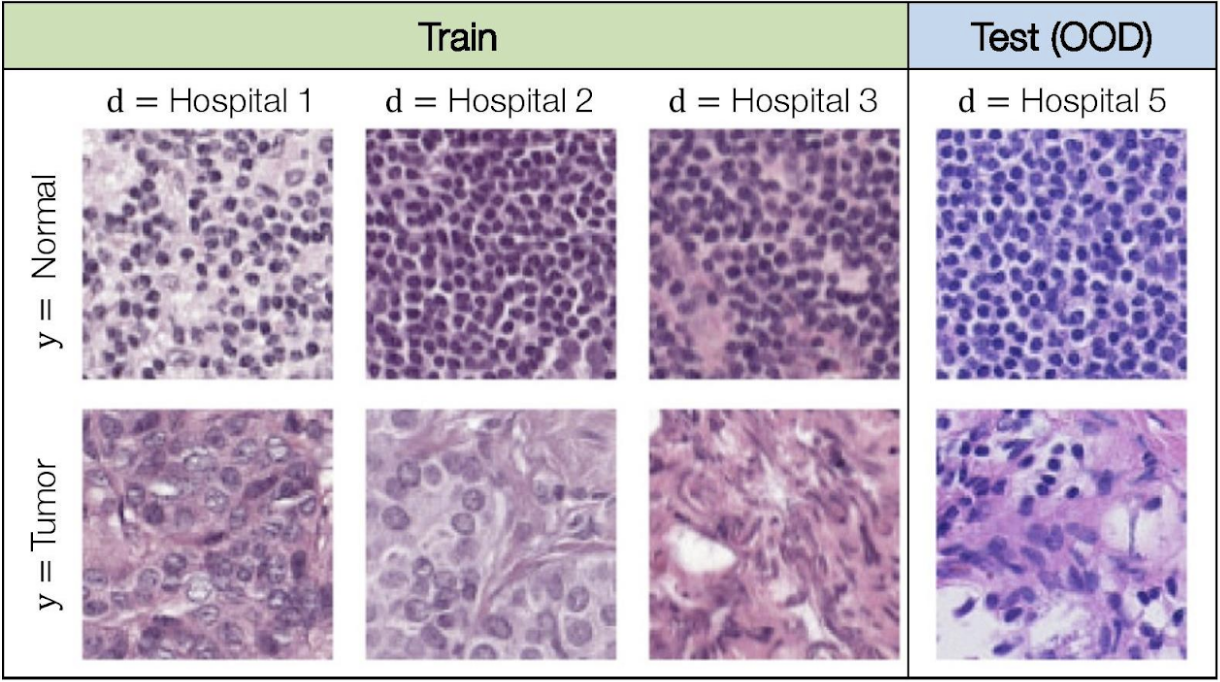
</div>

In [2]:
WILDS_PATH = '/home/data/wilds'
DOWNLOAD = False  # set to True for first run
N = 2000  # size of reference set

In [3]:
def stream_camelyon(
    split: str='train', 
    img_size: Tuple[int]=(96,96), 
    root_dir: str=None, 
    download: bool=False
) -> Generator:

    camelyon = get_dataset('camelyon17', root_dir=root_dir, download=download)
    ds = camelyon.get_subset(
        split, 
        transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
    )
    ds_iter = iter(get_train_loader('standard', ds, batch_size=1))

    while True:
        try:
            img = next(ds_iter)[0][0]
        except Exception:
            ds_iter = iter(get_train_loader('standard', ds, batch_size=1))
            img = next(ds_iter)[0][0]
        yield img.numpy()

stream_p = stream_camelyon(split='train', root_dir=WILDS_PATH, download=DOWNLOAD)
stream_q_h0 = stream_camelyon(split='id_val', root_dir=WILDS_PATH, download=DOWNLOAD)
stream_q_h1 = stream_camelyon(split='test', root_dir=WILDS_PATH, download=DOWNLOAD)

x_ref = np.stack([next(stream_p) for _ in range(N)], axis=0)

Shown below are samples from the pre-change distribution:

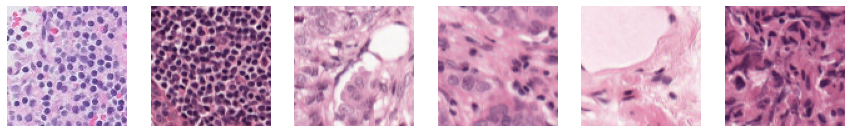

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,4))
for i in range(6):
    axs[i].imshow(np.transpose(next(stream_p), (1,2,0)))
    axs[i].axis('off')

And samples from the post-change distribution:

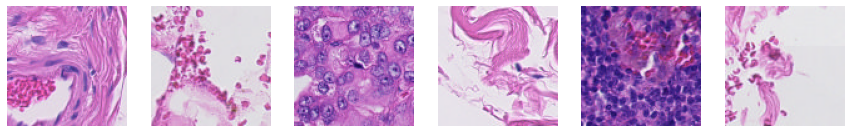

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,4))
for i in range(6):
    axs[i].imshow(np.transpose(next(stream_q_h1), (1,2,0)))
    axs[i].axis('off')

## Drift Detection

As the test statistic we'll use an estimate of $MMD_k$ that can be updated incrementally and therefore operate on overlapping windows.

### Kernel

As a projection to use as part of the kernel we'll train an autoencoder in order to define a more structured representational space of lower dimension. It is important that trained preprocessing components are trained on a split of data that doesn't then form part of the reference data passed to the drift detector.

In [6]:
ENC_DIM = 32
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3

In [7]:
encoder = nn.Sequential(
    nn.Conv2d(3, 8, 5, stride=3, padding=1),    # [batch, 8, 32, 32]
    nn.ReLU(),
    nn.Conv2d(8, 12, 4, stride=2, padding=1),   # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.Conv2d(12, 16, 4, stride=2, padding=1),   # [batch, 16, 8, 8]
    nn.ReLU(),
    nn.Conv2d(16, 20, 4, stride=2, padding=1),   # [batch, 20, 4, 4]
    nn.ReLU(),
    nn.Conv2d(20, ENC_DIM, 4, stride=1, padding=0),   # [batch, enc_dim, 1, 1]
    nn.Flatten(), 
)
decoder = nn.Sequential(
    nn.Unflatten(1, (ENC_DIM, 1, 1)),
    nn.ConvTranspose2d(ENC_DIM, 20, 4, stride=1, padding=0),  # [batch, 20, 4, 4]
    nn.ReLU(),
    nn.ConvTranspose2d(20, 16, 4, stride=2, padding=1),  # [batch, 16, 8, 8]
    nn.ReLU(),
    nn.ConvTranspose2d(16, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
    nn.ReLU(),
    nn.ConvTranspose2d(12, 8, 4, stride=2, padding=1),  # [batch, 8, 32, 32]
    nn.ReLU(),
    nn.ConvTranspose2d(8, 3, 5, stride=3, padding=1),   # [batch, 3, 96, 96]
    nn.Sigmoid(),
)
ae = nn.Sequential(encoder, decoder).to(device)

x_fit, x_ref = np.split(x_ref, [len(x_ref)//2])
x_fit = torch.as_tensor(x_fit)
x_fit_dl = DataLoader(TensorDataset(x_fit, x_fit), BATCH_SIZE, shuffle=True)

We can train the autoencoder using a helper function provided for convenience in `alibi-detect`.

In [8]:
from alibi_detect.models.pytorch import trainer

trainer(ae, nn.MSELoss(), x_fit_dl, device, learning_rate=LEARNING_RATE, epochs=EPOCHS)

2021-07-28 12:07:11.937658: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Epoch 5/5: 100%|███████████████████████████████████████████████████████| 32/32 [00:00<00:00, 144.17it/s, loss=0.0169]


The preprocessing/projection functions are expected to map numpy arrays to numpy array, so we wrap the encoder within the function below.

In [9]:
def encoder_fn(x: np.ndarray) -> np.ndarray:
    x = torch.as_tensor(x).to(device)
    with torch.no_grad():
        x_proj = encoder(x)
    return x_proj.cpu().numpy()

### Defining the detector

When defining the detector we must pass the reference data, desired ERT, and window size. The thresholds are configured via simulation in an initial configuration phase.

In [10]:
ERT = 150  # expected run-time in absence of change
W = 20  # size of test window
B = 50_000  # number of simulations to configure threshold

In [11]:
from alibi_detect.cd import MMDDriftOnline

dd = MMDDriftOnline(x_ref, ERT, W, backend='pytorch', preprocess_fn=encoder_fn)

Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.61it/s]


### Applying the detector

In [12]:
def compute_runtime(detector: Callable, stream: Generator) -> int:

    t = 0
    detector.reset()
    detected = False

    while not detected:
        t += 1
        z = next(stream)
        pred = detector.predict(z)
        detected = pred['data']['is_drift']
    print(t)
    return t

In [13]:
times_h0 = [compute_runtime(dd, stream_q_h0) for i in range(15)]
print(f"Average runtime in absence of change: {np.array(times_h0).mean()}")

352
171
10
246
111
37
517
46
25
472
27
94
36
135
119
Average runtime in absence of change: 159.86666666666667


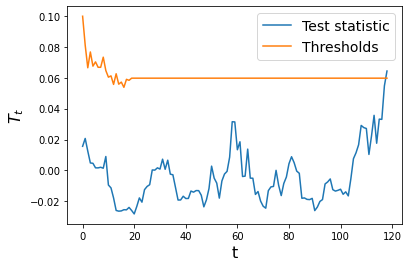

In [14]:
ts = np.arange(dd.t)
plt.plot(ts, dd.test_stats, label='Test statistic')
plt.plot(ts, dd.thresholds, label='Thresholds')
plt.xlabel('t', fontsize=16)
plt.ylabel('$T_t$', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [15]:
times_h1 = [compute_runtime(dd, stream_q_h1) for i in range(15)]
print(f"Average detection delay following change: {np.array(times_h1).mean()}")

9
5
8
14
14
12
10
10
7
14
14
12
17
9
10
Average detection delay following change: 11.0


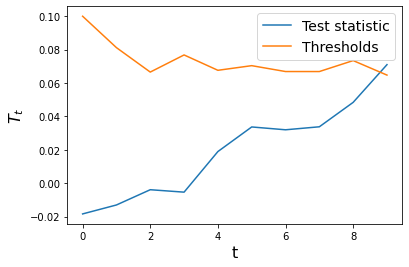

In [16]:
ts = np.arange(dd.t)
plt.plot(ts, dd.test_stats, label='Test statistic')
plt.plot(ts, dd.thresholds, label='Thresholds')
plt.xlabel('t', fontsize=16)
plt.ylabel('$T_t$', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()